<h3><center>Predicting Stroke Risk</center></h3>   

    
<center>Sam Loyd</center>
<center>June 2021</center> 

In [1]:
# Required Modules
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
# import sklearn.linear_model as lm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import *
from imblearn.combine import SMOTETomek
# from xgboost import XGBClassifier
from collections import Counter
from pycaret.classification import *
from sklearn import metrics

## Data Analysis - EDA

In [2]:
# Pull in data for stroke data 
stroke_df = pd.read_csv("data\\healthcare-dataset-stroke-data.csv")

In [3]:
stroke_df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [4]:
# Correct data types
stroke_df['stroke'] = stroke_df['stroke'].astype(bool)
stroke_df['hypertension'] = stroke_df['hypertension'].astype(bool)
stroke_df['heart_disease'] = stroke_df['heart_disease'].astype(bool)

In [5]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,False,True,Yes,Private,Urban,228.69,36.6,formerly smoked,True
1,51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
2,31112,Male,80.0,False,True,Yes,Private,Rural,105.92,32.5,never smoked,True
3,60182,Female,49.0,False,False,Yes,Private,Urban,171.23,34.4,smokes,True
4,1665,Female,79.0,True,False,Yes,Self-employed,Rural,174.12,24.0,never smoked,True


In [6]:
# Apply profie and create html report
# Commented out for performance
# prof = ProfileReport(stroke_df,title="Pandas Profiling Report - Stroke Data", explorative=True)
# prof.to_file(output_file='stroke-pandas-profile-report.html')

# Please see stroke-pandas-profile-report.html for a full analysis 

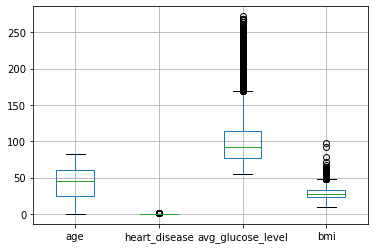

In [7]:
# Pandas-profiling is lacking in outlier analysis visuals so those are included here.

# Box and whisker plots for outlier analysis.
boxplot = stroke_df.boxplot(column=['age', 'heart_disease', 'avg_glucose_level','bmi'])

While outliers were discovered, they were within acceptable ranges according to domain knowledge.
They will not be removed.

## Data Wrangling  
Impute missing values found in the EDA process using pandas-profile report.

In [8]:
# Count nulls
stroke_df.bmi.isnull().sum()

201

In [9]:
# Take a deeper look at these
stroke_null = stroke_df[stroke_df.bmi.isnull()]

In [10]:
# View 
stroke_null.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,False,False,Yes,Self-employed,Rural,202.21,NaN,never smoked,True
8,27419,Female,59.0,False,False,Yes,Private,Rural,76.15,NaN,Unknown,True
13,8213,Male,78.0,False,True,Yes,Private,Urban,219.84,NaN,Unknown,True
19,25226,Male,57.0,False,True,No,Govt_job,Urban,217.08,NaN,Unknown,True
27,61843,Male,58.0,False,False,Yes,Private,Rural,189.84,NaN,Unknown,True


In [11]:
# about 25%
stroke_null.stroke.value_counts()

False    161
True      40
Name: stroke, dtype: int64

In [12]:
# about 5%
stroke_df.stroke.value_counts()

False    4861
True      249
Name: stroke, dtype: int64

That seems too many data points that have had strokes to throw out given that it is already only 5%.  
As in most cases of missingness there are no good options, but in this case, it does the least harm to impute the mean.

In [13]:
# View
stroke_df.describe()

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,4909.000000
mean,36517.829354,43.226614,106.147677,28.893237
std,21161.721625,22.612647,45.283560,7.854067
min,67.000000,0.080000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.500000
50%,36932.000000,45.000000,91.885000,28.100000
75%,54682.000000,61.000000,114.090000,33.100000
max,72940.000000,82.000000,271.740000,97.600000


In [14]:
# Gather mean for imputation
bmi_mean = stroke_df.bmi.mean()

In [15]:
# Capture where it was null
stroke_df['null_bmi'] = np.where(stroke_df.bmi.isnull(), 1, 0)

In [16]:
# Show value
bmi_mean

28.893236911794673

In [17]:
# Set to mean
stroke_df = stroke_df.fillna(bmi_mean)

In [18]:
# Contrast effect on statistics
stroke_df.describe()

,id,age,avg_glucose_level,bmi,null_bmi
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,106.147677,28.893237,0.039335
std,21161.721625,22.612647,45.283560,7.698018,0.194409
min,67.000000,0.080000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,271.740000,97.600000,1.000000


In [19]:
# Verify change
stroke_df.bmi.isnull().sum()

0

In [20]:
stroke_df.null_bmi.value_counts()

0    4909
1     201
Name: null_bmi, dtype: int64

## Model Prep

In [21]:
# Prepare for modeling
# Make numeric
stroke_df['stroke'] = stroke_df['stroke'].astype(int)
stroke_df['hypertension'] = stroke_df['hypertension'].astype(int)
stroke_df['heart_disease'] = stroke_df['heart_disease'].astype(int)

In [22]:
# Binary values
# 1 unknown, but I made it female since it was the most common
stroke_df['gender'] = np.where(stroke_df['gender']=='male', 1, 0)

stroke_df['Residence_type'] = np.where(stroke_df['Residence_type']=='Urban', 1, 0)
stroke_df['ever_married'] = np.where(stroke_df['ever_married']=='Yes', 1, 0)

### One Hot Encoding

In [23]:
work_type_one_hot = pd.get_dummies(stroke_df['work_type'])

In [24]:
work_type_one_hot.columns = ['work_type_gov', 'work_type_never','work_type_priv', 'work_type_self','work_type_child']

In [25]:
smoking_status_one_hot = pd.get_dummies(stroke_df['smoking_status'])

In [26]:
smoking_status_one_hot.columns = ['smok_stat_unk', 'smok_stat_form','smoke_stat_nev','smok_stat_curr']

In [27]:
model_stroke_df = pd.concat([stroke_df,work_type_one_hot,smoking_status_one_hot], axis = 1)

In [28]:
# Clean up
model_stroke_df.drop('work_type', axis=1, inplace=True)
model_stroke_df.drop('Residence_type', axis=1, inplace=True) 
model_stroke_df.drop('smoking_status', axis=1, inplace=True) 
model_stroke_df.drop('id', axis=1, inplace=True) 

In [29]:
model_stroke_df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,null_bmi,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr
0,0,67.0,0,1,1,228.69,36.600000,1,0,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,202.21,28.893237,1,1,0,0,0,1,0,0,0,1,0
2,0,80.0,0,1,1,105.92,32.500000,1,0,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,171.23,34.400000,1,0,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,174.12,24.000000,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,83.75,28.893237,0,1,0,0,1,0,0,0,0,1,0
5106,0,81.0,0,0,1,125.20,40.000000,0,0,0,0,0,1,0,0,0,1,0
5107,0,35.0,0,0,1,82.99,30.600000,0,0,0,0,0,1,0,0,0,1,0
5108,0,51.0,0,0,1,166.29,25.600000,0,0,0,0,1,0,0,0,1,0,0


### Normalize the numeric data
Non Gaussian

In [30]:
# Normalize with minmax_scale
model_stroke_df[['age','avg_glucose_level','bmi']] = minmax_scale(model_stroke_df[['age','avg_glucose_level','bmi']])

In [31]:
model_stroke_df

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,null_bmi,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr
0,0,0.816895,0,1,1,0.801265,0.301260,1,0,0,0,1,0,0,0,1,0,0
1,0,0.743652,0,0,1,0.679023,0.212981,1,1,0,0,0,1,0,0,0,1,0
2,0,0.975586,0,1,1,0.234512,0.254296,1,0,0,0,1,0,0,0,0,1,0
3,0,0.597168,0,0,1,0.536008,0.276060,1,0,0,0,1,0,0,0,0,0,1
4,0,0.963379,1,0,1,0.549349,0.156930,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,0.975586,1,0,1,0.132167,0.212981,0,1,0,0,1,0,0,0,0,1,0
5106,0,0.987793,0,0,1,0.323516,0.340206,0,0,0,0,0,1,0,0,0,1,0
5107,0,0.426270,0,0,1,0.128658,0.232532,0,0,0,0,0,1,0,0,0,1,0
5108,0,0.621582,0,0,1,0.513203,0.175258,0,0,0,0,1,0,0,0,1,0,0


In [32]:
# Create X from the features
X = model_stroke_df.drop(columns=['stroke'])

# Create y from output
y = model_stroke_df[['stroke']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [33]:
# Treating Imbalance Data using SMOTE
# smote=SMOTETomek()
# X_train,y_train=smote.fit_resample(X_train,y_train)

In [34]:
# Much better balance
y_train.value_counts() 

stroke
0         2917
1          149
dtype: int64

## Model Selection with PyCaret

In [35]:
# PyCaret requires them in one dataframe
X_train_caret_cat = X_train.copy()
X_train_caret_cat['stroke'] = y_train['stroke']
X_train_caret_cat

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,null_bmi,work_type_gov,work_type_never,work_type_priv,work_type_self,work_type_child,smok_stat_unk,smok_stat_form,smoke_stat_nev,smok_stat_curr,stroke
3861,0,0.548340,0,0,1,0.047826,0.186712,0,0,0,1,0,0,1,0,0,0,0
2704,0,0.475098,0,0,1,0.088496,0.217640,0,0,0,0,1,0,0,0,0,1,0
4800,0,0.902344,0,0,1,0.262303,0.130584,0,1,0,0,0,0,0,0,1,0,0
4239,0,0.877930,0,0,1,0.224633,0.256586,0,0,0,0,1,0,0,1,0,0,0
655,0,0.340820,0,0,1,0.043948,0.135166,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4472,0,0.169922,0,0,0,0.039793,0.138603,0,0,0,0,0,1,1,0,0,0,0
1562,0,0.987793,1,0,1,0.016573,0.277205,0,0,0,1,0,0,0,0,1,0,0
3212,0,0.597168,1,0,1,0.037116,0.148912,0,1,0,0,0,0,0,1,0,0,0
2000,0,0.658203,0,0,1,0.048795,0.127148,0,0,0,1,0,0,0,0,1,0,0


### Deal with stroke being extremely imbalanced in this data set using oversampling technique.

In [36]:
exp_clf_cat = setup(X_train_caret_cat, target='stroke', fix_imbalance = True, fix_imbalance_method=ADASYN())

,Description,Value
0,session_id,3544
1,Target,stroke
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(3066, 18)"
5,Missing Values,False
6,Numeric Features,17
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [37]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [38]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9557,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0160
xgboost,Extreme Gradient Boosting,0.9161,0.7279,0.2189,0.1598,0.1822,0.1409,0.1433,0.3450
lightgbm,Light Gradient Boosting Machine,0.9063,0.7314,0.1656,0.1157,0.1341,0.0872,0.0894,0.2500
rf,Random Forest Classifier,0.8747,0.7372,0.2100,0.0984,0.1326,0.0767,0.0826,0.1610
et,Extra Trees Classifier,0.8742,0.7053,0.2100,0.0939,0.1277,0.0716,0.0790,0.1360
catboost,CatBoost Classifier,0.8719,0.6997,0.2189,0.0969,0.1328,0.0763,0.0837,1.3080
dt,Decision Tree Classifier,0.8490,0.5681,0.2600,0.0981,0.1404,0.0799,0.0901,0.0180
gbc,Gradient Boosting Classifier,0.7959,0.7380,0.4800,0.1058,0.1729,0.1085,0.1495,0.1480
knn,K Neighbors Classifier,0.7833,0.6586,0.3700,0.0814,0.1328,0.0650,0.0890,0.0330
svm,SVM - Linear Kernel,0.7497,0.0000,0.6844,0.1148,0.1956,0.1300,0.2045,0.0180


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

## Parameter Tuning

In [120]:
# Select best model
pmt_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7907,0.7907,0.5556,0.1087,0.1818,0.1202,0.1741
1,0.7535,0.7917,0.8000,0.1356,0.2319,0.1655,0.2601
2,0.7070,0.7063,0.6000,0.0923,0.1600,0.0863,0.1432
3,0.7395,0.7137,0.5000,0.0893,0.1515,0.0788,0.1205
4,0.7581,0.8615,0.8000,0.1379,0.2353,0.1694,0.2639
5,0.7860,0.8283,0.8000,0.1538,0.2581,0.1953,0.2879
6,0.7523,0.8520,0.8889,0.1333,0.2319,0.1713,0.2839
7,0.7150,0.7274,0.4444,0.0667,0.1159,0.0462,0.0765
8,0.7290,0.7637,0.6667,0.0984,0.1714,0.1059,0.1771
9,0.7477,0.7713,0.6667,0.1053,0.1818,0.1177,0.1897


In [121]:
# Find best parameters 
pmt_model = tune_model(pmt_model,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7814,0.7956,0.5556,0.1042,0.1754,0.1129,0.1668
1,0.7535,0.7893,0.8000,0.1356,0.2319,0.1655,0.2601
2,0.7070,0.6966,0.5000,0.0794,0.1370,0.0617,0.1004
3,0.7442,0.7200,0.6000,0.1053,0.1791,0.1086,0.1676
4,0.7674,0.8615,0.8000,0.1429,0.2424,0.1775,0.2715
5,0.7767,0.8298,0.8000,0.1481,0.2500,0.1861,0.2795
6,0.7477,0.8585,0.8889,0.1311,0.2286,0.1676,0.2803
7,0.7243,0.7371,0.5556,0.0833,0.1449,0.0775,0.1284
8,0.7430,0.7545,0.5556,0.0893,0.1538,0.0877,0.1401
9,0.7664,0.7610,0.6667,0.1132,0.1935,0.1311,0.2034


In [122]:
# Lets look at them
plot_model(pmt_model, plot='parameter')

,Parameters
C,3.753
class_weight,balanced
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


In [123]:
# Finalize the model
final_pmt_model = finalize_model(pmt_model)

## Test Data

In [124]:
# predict test data
test_predictions = predict_model(final_pmt_model, data=X_test)
test_predictions.Label

4673    0
3232    1
3694    0
1070    1
4163    0
       ..
2030    0
4555    0
1056    0
854     0
4288    0
Name: Label, Length: 1022, dtype: int32

In [125]:
# Check stats
print(classification_report(y_test, test_predictions.Label))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       962
           1       0.16      0.73      0.26        60

    accuracy                           0.75      1022
   macro avg       0.57      0.74      0.56      1022
weighted avg       0.93      0.75      0.82      1022



[Text(0, 0.5, 'None'), Text(0, 1.5, 'Stroke')]

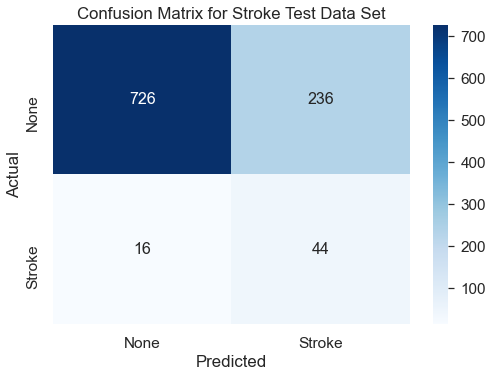

<Figure size 720x504 with 0 Axes>

In [126]:
# Draw confusion matrix 
data = confusion_matrix(y_test, test_predictions.Label)
ax= plt.subplot()

df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,ax = ax, annot_kws={"size": 16},fmt='d')# font size
ax.set_title('Confusion Matrix for Stroke Test Data Set') 
ax.xaxis.set_ticklabels(['None', 'Stroke'])   
ax.yaxis.set_ticklabels(['None', 'Stroke'])

## Validation Data

In [127]:
# predict validation data
val_predictions = predict_model(final_pmt_model, data=X_val)
val_predictions.Label

3234    1
3968    0
3335    0
1617    1
4701    0
       ..
830     0
498     0
3427    0
271     0
5059    0
Name: Label, Length: 1022, dtype: int32

In [128]:
# Check stats
print(classification_report(y_val, val_predictions.Label))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       982
           1       0.11      0.75      0.19        40

    accuracy                           0.74      1022
   macro avg       0.55      0.75      0.52      1022
weighted avg       0.95      0.74      0.82      1022



[Text(0, 0.5, 'None'), Text(0, 1.5, 'Stroke')]

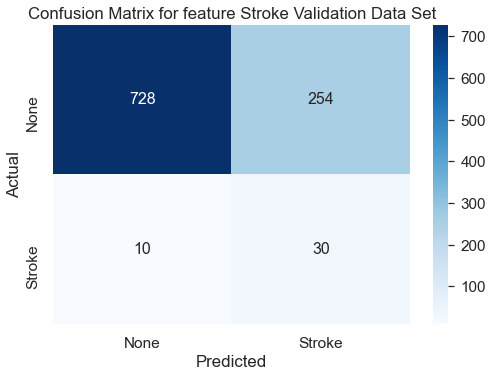

<Figure size 720x504 with 0 Axes>

In [129]:
# Draw confusion matrix 
data = confusion_matrix(y_val, val_predictions.Label)
ax= plt.subplot()

df_cm = pd.DataFrame(data, columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,ax = ax, annot_kws={"size": 16},fmt='d')# font size
ax.set_title('Confusion Matrix for feature Stroke Validation Data Set') 
ax.xaxis.set_ticklabels(['None', 'Stroke'])   
ax.yaxis.set_ticklabels(['None', 'Stroke'])

In [130]:
# Gather metrics 
fpr, tpr, thresholds = metrics.roc_curve(y_val, val_predictions.Label)
auc = metrics.roc_auc_score(y_val, val_predictions.Label)
auc = round(auc,2)
print('AUC: %.2f' % auc)

AUC: 0.75


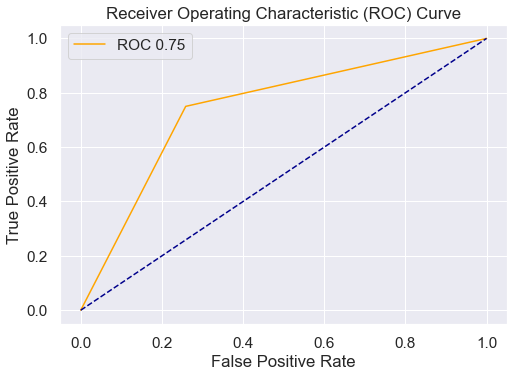

In [131]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC '+ str(auc))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve' )
    plt.legend(frameon=True)
    plt.show()

plot_roc_curve(fpr, tpr)